# The Gram–Schmidt Process — From Intuition to QR

## Why Do We Need Orthogonal Vectors?

Imagine you're trying to describe the location of objects in a room. If you use two directions that are almost the same (like "slightly north" and "slightly northeast"), it becomes confusing and imprecise. But if you use perpendicular directions (like "north" and "east"), everything becomes crystal clear.

**This is exactly what Gram–Schmidt does for vector spaces!**

**Goal:** Starting from linearly independent vectors $v_1,\dots,v_n$, construct an **orthonormal basis** $e_1,\dots,e_n$.

**Why is this powerful?**
- 🎯 **Dot products become coordinates**: $x \cdot e_i$ gives the $i$-th coordinate
- 🔄 **Inverses become transposes**: $Q^{-1} = Q^T$ (much faster to compute!)
- 📏 **Transformations preserve lengths and angles** (orthogonal matrices)
- 🧮 **Simplifies many calculations** in linear algebra

## What You'll Learn:
- 🎨 **Visual intuition**: How projections "peel off" parallel components
- 📐 **Mathematical formulas**: Classical and Modified Gram–Schmidt algorithms
- 🔢 **Numerical stability**: Why some methods work better than others
- 🏗️ **QR decomposition**: The powerful factorization that emerges naturally
- 💪 **Hands-on exercises**: Practice with real examples

In [10]:

import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)
print("Libraries ready.")


Libraries ready.


## 1) The Core Intuition: "Peeling Off" Parallel Components

### 🎯 The Big Picture
Think of Gram–Schmidt like **straightening out a bent coordinate system**. You take tilted, overlapping directions and turn them into clean, perpendicular axes.

### 🔍 The Mathematical Recipe

**Step 1: Start with the first vector**
- Take $v_1$ and normalize it: $e_1 = \frac{v_1}{\|v_1\|}$
- Now $e_1$ is our first orthonormal basis vector

**Step 2: Remove the "shadow" of $e_1$ from $v_2$**

Any vector $v$ can be split into two parts when we have a unit vector $e_1$:
$$ v = \underbrace{(v \cdot e_1) e_1}_{\text{parallel to } e_1} \; + \; \underbrace{v - (v \cdot e_1)e_1}_{\text{perpendicular to } e_1} $$

**The perpendicular part is what we want!**

### 🔄 Repeat the Process

At step $k$, we remove components along ALL previous orthonormal vectors:
$$
u_k = v_k - \sum_{i=1}^{k-1} (v_k \cdot e_i) e_i
$$

Then normalize: $e_k = \frac{u_k}{\|u_k\|}$

### 🎨 Geometric Interpretation
- $(v_k \cdot e_i)$ measures "how much of $v_k$ points in direction $e_i$"
- $(v_k \cdot e_i) e_i$ is the "shadow" or projection of $v_k$ onto $e_i$
- Subtracting all these shadows leaves only the "new" direction

**Note:** If you're working with non-unit vectors, use the general projection formula:  
$$\text{proj}_{u}(v) = \frac{v \cdot u}{u \cdot u} u$$

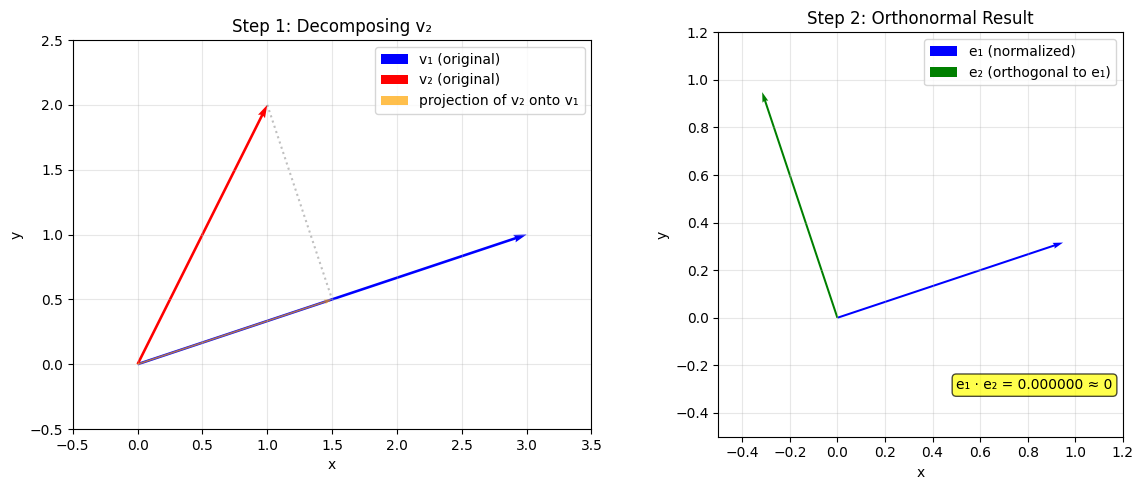

Original vectors:
v₁ = [3 1]
v₂ = [1 2]

After Gram-Schmidt:
e₁ = [0.9487 0.3162]
e₂ = [-0.3162  0.9487]

Verification:
||e₁|| = 1.000000
||e₂|| = 1.000000
e₁ · e₂ = 0.000000


In [11]:
# Let's visualize the projection concept with a simple example
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Example vectors
v1 = np.array([3, 1])
v2 = np.array([1, 2])

# Step 1: Normalize v1 to get e1
e1 = v1 / np.linalg.norm(v1)

# Step 2: Project v2 onto e1
proj_v2_on_e1 = np.dot(v2, e1) * e1

# Step 3: Get the perpendicular component
u2 = v2 - proj_v2_on_e1

# Plot the original vectors
ax1.quiver(0, 0, v1[0], v1[1], angles='xy', scale_units='xy', scale=1, 
           color='blue', width=0.005, label='v₁ (original)')
ax1.quiver(0, 0, v2[0], v2[1], angles='xy', scale_units='xy', scale=1, 
           color='red', width=0.005, label='v₂ (original)')

# Plot the projection
ax1.quiver(0, 0, proj_v2_on_e1[0], proj_v2_on_e1[1], angles='xy', scale_units='xy', scale=1, 
           color='orange', width=0.003, alpha=0.7, label='projection of v₂ onto v₁')

# Draw a line from v2 to its projection to show the perpendicular component
ax1.plot([v2[0], proj_v2_on_e1[0]], [v2[1], proj_v2_on_e1[1]], 
         color='gray', linestyle=':', alpha=0.5)

ax1.set_xlim(-0.5, 3.5)
ax1.set_ylim(-0.5, 2.5)
ax1.grid(True, alpha=0.3)
ax1.set_aspect('equal')
ax1.legend()
ax1.set_title('Step 1: Decomposing v₂')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# Show the final orthogonal result
e2 = u2 / np.linalg.norm(u2)

ax2.quiver(0, 0, e1[0], e1[1], angles='xy', scale_units='xy', scale=1, 
           color='blue', width=0.005, label='e₁ (normalized)')
ax2.quiver(0, 0, e2[0], e2[1], angles='xy', scale_units='xy', scale=1, 
           color='green', width=0.005, label='e₂ (orthogonal to e₁)')

# Verify orthogonality
dot_product = np.dot(e1, e2)
ax2.text(0.5, -0.3, f'e₁ · e₂ = {dot_product:.6f} ≈ 0', 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

ax2.set_xlim(-0.5, 1.2)
ax2.set_ylim(-0.5, 1.2)
ax2.grid(True, alpha=0.3)
ax2.set_aspect('equal')
ax2.legend()
ax2.set_title('Step 2: Orthonormal Result')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

plt.tight_layout()
plt.show()

print(f"Original vectors:")
print(f"v₁ = {v1}")
print(f"v₂ = {v2}")
print(f"\nAfter Gram-Schmidt:")
print(f"e₁ = {e1}")
print(f"e₂ = {e2}")
print(f"\nVerification:")
print(f"||e₁|| = {np.linalg.norm(e1):.6f}")
print(f"||e₂|| = {np.linalg.norm(e2):.6f}")
print(f"e₁ · e₂ = {np.dot(e1, e2):.6f}")

## 2) Helper Functions: Our Gram–Schmidt Toolkit

We'll implement two versions of the Gram–Schmidt algorithm:

### 🔧 **Function Overview:**
- `is_orthonormal(Q)`: Verifies that $Q^TQ \approx I$ (quality check for our results)
- `classical_gs(V)`: **Classical Gram–Schmidt (CGS)** - conceptually simple but can accumulate errors
- `modified_gs(V)`: **Modified Gram–Schmidt (MGS)** - numerically more stable for real-world use

### 📊 **What They Return:**
Both algorithms return:
- **Q**: Matrix with orthonormal columns (what we want!)
- **R**: Upper triangular matrix containing the "recipe" (projection coefficients)

The key relationship: **V = QR** (this is the famous QR decomposition!)

### 🤔 **Classical vs Modified: What's the Difference?**

**Classical GS**: 
- Computes all projections using original vectors
- Can accumulate rounding errors when vectors are nearly dependent

**Modified GS**: 
- Updates vectors "on the fly" after each orthogonalization step
- More robust against numerical errors
- Recommended for practical applications

In [12]:

def is_orthonormal(Q, atol=1e-10):
    I = Q.T @ Q
    return np.allclose(I, np.eye(Q.shape[1]), atol=atol), I

def classical_gs(V):
    """Classical Gram–Schmidt.
    V: (m,n) with linearly independent columns.
    Returns Q (m,n), R (n,n) so that V ≈ Q R and Q has orthonormal columns.
    """
    m, n = V.shape
    Q = np.zeros((m, n), dtype=float)
    R = np.zeros((n, n), dtype=float)
    for j in range(n):
        v = V[:, j].astype(float).copy()
        for i in range(j):
            R[i, j] = Q[:, i] @ v
            v = v - R[i, j] * Q[:, i]
        R[j, j] = np.linalg.norm(v)
        if R[j, j] == 0:
            raise ValueError("Input columns are linearly dependent.")
        Q[:, j] = v / R[j, j]
    return Q, R

def modified_gs(V):
    """Modified Gram–Schmidt.
    Numerically more stable: orthogonalize one vector at a time against the
    current e_i, updating the residual in-place.
    """
    m, n = V.shape
    Q = np.zeros((m, n), dtype=float)
    R = np.zeros((n, n), dtype=float)
    W = V.astype(float).copy()
    for i in range(n):
        vi = W[:, i]
        R[i, i] = np.linalg.norm(vi)
        if R[i, i] == 0:
            raise ValueError("Input columns are linearly dependent.")
        Q[:, i] = vi / R[i, i]
        for j in range(i+1, n):
            R[i, j] = Q[:, i] @ W[:, j]
            W[:, j] = W[:, j] - R[i, j] * Q[:, i]
    return Q, R


## 3) Hands-on: from two tilted vectors to an orthonormal pair (2D)

Start with non-orthogonal vectors  
$v_1=[3,1]^\top,\; v_2=[1,1]^\top$.  
We expect Gram–Schmidt to give unit vectors $e_1,e_2$ at right angles.

## 2.5) 📝 Manual Walkthrough: Step-by-Step Calculation

Let's work through Gram–Schmidt by hand with simple vectors to build intuition.

**Given vectors:** $v_1 = \begin{bmatrix} 3 \\ 1 \end{bmatrix}$, $v_2 = \begin{bmatrix} 1 \\ 1 \end{bmatrix}$

### Step 1: Normalize the first vector
$$e_1 = \frac{v_1}{\|v_1\|} = \frac{\begin{bmatrix} 3 \\ 1 \end{bmatrix}}{\sqrt{3^2 + 1^2}} = \frac{\begin{bmatrix} 3 \\ 1 \end{bmatrix}}{\sqrt{10}} = \begin{bmatrix} 3/\sqrt{10} \\ 1/\sqrt{10} \end{bmatrix}$$

### Step 2: Remove the $e_1$ component from $v_2$

**a) Compute the projection coefficient:**
$$v_2 \cdot e_1 = \begin{bmatrix} 1 \\ 1 \end{bmatrix} \cdot \begin{bmatrix} 3/\sqrt{10} \\ 1/\sqrt{10} \end{bmatrix} = \frac{3 + 1}{\sqrt{10}} = \frac{4}{\sqrt{10}}$$

**b) Compute the projection:**
$$\text{proj}_{e_1}(v_2) = (v_2 \cdot e_1) e_1 = \frac{4}{\sqrt{10}} \begin{bmatrix} 3/\sqrt{10} \\ 1/\sqrt{10} \end{bmatrix} = \begin{bmatrix} 12/10 \\ 4/10 \end{bmatrix} = \begin{bmatrix} 1.2 \\ 0.4 \end{bmatrix}$$

**c) Subtract to get the perpendicular component:**
$$u_2 = v_2 - \text{proj}_{e_1}(v_2) = \begin{bmatrix} 1 \\ 1 \end{bmatrix} - \begin{bmatrix} 1.2 \\ 0.4 \end{bmatrix} = \begin{bmatrix} -0.2 \\ 0.6 \end{bmatrix}$$

### Step 3: Normalize $u_2$ to get $e_2$
$$\|u_2\| = \sqrt{(-0.2)^2 + 0.6^2} = \sqrt{0.04 + 0.36} = \sqrt{0.4} = 0.6325$$

$$e_2 = \frac{u_2}{\|u_2\|} = \frac{\begin{bmatrix} -0.2 \\ 0.6 \end{bmatrix}}{0.6325} = \begin{bmatrix} -0.3162 \\ 0.9487 \end{bmatrix}$$

### ✅ Verification:
- $\|e_1\| = 1$ ✓
- $\|e_2\| = 1$ ✓  
- $e_1 \cdot e_2 = 0$ ✓

Let's verify this with code:

In [13]:
# Manual calculation verification
v1_manual = np.array([3., 1.])
v2_manual = np.array([1., 1.])

# Step 1: Normalize v1
e1_manual = v1_manual / np.linalg.norm(v1_manual)
print("Step 1 - Normalize v₁:")
print(f"||v₁|| = √({v1_manual[0]}² + {v1_manual[1]}²) = √{v1_manual[0]**2 + v1_manual[1]**2} = {np.linalg.norm(v1_manual):.4f}")
print(f"e₁ = v₁/||v₁|| = [{e1_manual[0]:.4f}, {e1_manual[1]:.4f}]")

# Step 2: Project v2 onto e1
proj_coeff = np.dot(v2_manual, e1_manual)
projection = proj_coeff * e1_manual
u2_manual = v2_manual - projection

print(f"\nStep 2 - Remove e₁ component from v₂:")
print(f"v₂ · e₁ = {proj_coeff:.4f}")
print(f"proj_e₁(v₂) = [{projection[0]:.4f}, {projection[1]:.4f}]")
print(f"u₂ = v₂ - proj_e₁(v₂) = [{u2_manual[0]:.4f}, {u2_manual[1]:.4f}]")

# Step 3: Normalize u2
e2_manual = u2_manual / np.linalg.norm(u2_manual)
print(f"\nStep 3 - Normalize u₂:")
print(f"||u₂|| = {np.linalg.norm(u2_manual):.4f}")
print(f"e₂ = u₂/||u₂|| = [{e2_manual[0]:.4f}, {e2_manual[1]:.4f}]")

# Verification
print(f"\n✅ Verification:")
print(f"||e₁|| = {np.linalg.norm(e1_manual):.6f}")
print(f"||e₂|| = {np.linalg.norm(e2_manual):.6f}")
print(f"e₁ · e₂ = {np.dot(e1_manual, e2_manual):.6f}")

# Compare with our algorithm
V_manual = np.column_stack([v1_manual, v2_manual])
Q_algorithm, R_algorithm = modified_gs(V_manual)
print(f"\n🔍 Compare with algorithm:")
print(f"Manual e₁: [{e1_manual[0]:.4f}, {e1_manual[1]:.4f}]")
print(f"Algorithm e₁: [{Q_algorithm[0,0]:.4f}, {Q_algorithm[1,0]:.4f}]")
print(f"Manual e₂: [{e2_manual[0]:.4f}, {e2_manual[1]:.4f}]")
print(f"Algorithm e₂: [{Q_algorithm[0,1]:.4f}, {Q_algorithm[1,1]:.4f}]")

Step 1 - Normalize v₁:
||v₁|| = √(3.0² + 1.0²) = √10.0 = 3.1623
e₁ = v₁/||v₁|| = [0.9487, 0.3162]

Step 2 - Remove e₁ component from v₂:
v₂ · e₁ = 1.2649
proj_e₁(v₂) = [1.2000, 0.4000]
u₂ = v₂ - proj_e₁(v₂) = [-0.2000, 0.6000]

Step 3 - Normalize u₂:
||u₂|| = 0.6325
e₂ = u₂/||u₂|| = [-0.3162, 0.9487]

✅ Verification:
||e₁|| = 1.000000
||e₂|| = 1.000000
e₁ · e₂ = 0.000000

🔍 Compare with algorithm:
Manual e₁: [0.9487, 0.3162]
Algorithm e₁: [0.9487, 0.3162]
Manual e₂: [-0.3162, 0.9487]
Algorithm e₂: [-0.3162, 0.9487]


In [21]:

V2 = np.column_stack([[3.,1.], [1.,1.]])
Q2_cgs, R2_cgs = classical_gs(V2)
Q2_mgs, R2_mgs = modified_gs(V2)

print("Q (CGS) =\n", np.round(Q2_cgs, 4))
print("R (CGS) =\n", np.round(R2_cgs, 4))
ok, I = is_orthonormal(Q2_cgs)
print("Q^T Q ≈ I ?", ok, "\n", np.round(I, 4))

print("\nQ (MGS) =\n", np.round(Q2_mgs, 4))
print("R (MGS) =\n", np.round(R2_mgs, 4))
ok, I = is_orthonormal(Q2_mgs)
print("Q^T Q ≈ I ?", ok, "\n", np.round(I, 4))

print("\nCheck V ≈ Q R (CGS):\n", np.round(Q2_cgs @ R2_cgs, 4))
print("Original V:\n", V2)


Q (CGS) =
 [[ 0.9487 -0.3162]
 [ 0.3162  0.9487]]
R (CGS) =
 [[3.1623 1.2649]
 [0.     0.6325]]
Q^T Q ≈ I ? True 
 [[1. 0.]
 [0. 1.]]

Q (MGS) =
 [[ 0.9487 -0.3162]
 [ 0.3162  0.9487]]
R (MGS) =
 [[3.1623 1.2649]
 [0.     0.6325]]
Q^T Q ≈ I ? True 
 [[1. 0.]
 [0. 1.]]

Check V ≈ Q R (CGS):
 [[3. 1.]
 [1. 1.]]
Original V:
 [[3. 1.]
 [1. 1.]]


### Visualizing the 2D orthogonalization

We plot $v_1,v_2$ and the resulting orthonormal $e_1,e_2$ (columns of $Q$).

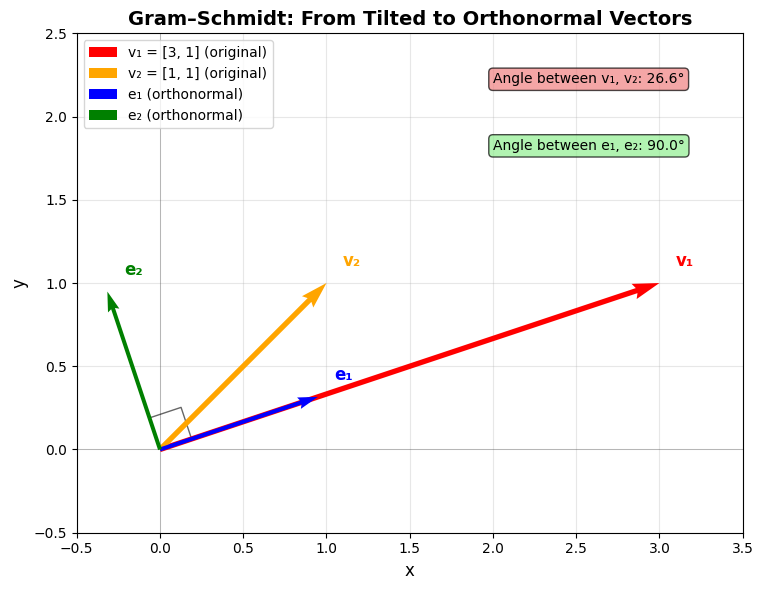

📊 Transformation Summary:
Original vectors: v₁=[3. 1.], v₂=[1. 1.]
Orthonormal result: e₁=[0.9487 0.3162], e₂=[-0.3162  0.9487]
✓ Both have unit length: ||e₁||=1.000000, ||e₂||=1.000000
✓ Perpendicular: e₁·e₂=0.000000
✓ Span same space: det([e₁ e₂])=1.000000 (preserves orientation)


In [16]:
plt.figure(figsize=(10, 6))
origin = np.zeros(2)
v1, v2 = V2[:,0], V2[:,1]
e1, e2 = Q2_mgs[:,0], Q2_mgs[:,1]

# Plot original vectors (thicker, with distinct colors)
plt.quiver(*origin, *v1, angles='xy', scale_units='xy', scale=1, 
           color='red', width=0.008, label='v₁ = [3, 1] (original)', zorder=3)
plt.quiver(*origin, *v2, angles='xy', scale_units='xy', scale=1, 
           color='orange', width=0.008, label='v₂ = [1, 1] (original)', zorder=3)

# Plot orthonormal vectors (different style)
plt.quiver(*origin, *e1, angles='xy', scale_units='xy', scale=1, 
           color='blue', width=0.006, label='e₁ (orthonormal)', zorder=4)
plt.quiver(*origin, *e2, angles='xy', scale_units='xy', scale=1, 
           color='green', width=0.006, label='e₂ (orthonormal)', zorder=4)

# Add vector labels at the tips
plt.text(v1[0]+0.1, v1[1]+0.1, 'v₁', fontsize=12, fontweight='bold', color='red')
plt.text(v2[0]+0.1, v2[1]+0.1, 'v₂', fontsize=12, fontweight='bold', color='orange')
plt.text(e1[0]+0.1, e1[1]+0.1, 'e₁', fontsize=12, fontweight='bold', color='blue')
plt.text(e2[0]+0.1, e2[1]+0.1, 'e₂', fontsize=12, fontweight='bold', color='green')

# Draw right angle symbol to show orthogonality
scale = 0.2
corner = scale * (e1 + e2)
plt.plot([scale*e1[0], corner[0], scale*e2[0]], 
         [scale*e1[1], corner[1], scale*e2[1]], 
         'k-', linewidth=1, alpha=0.6)

# Add angle measurements
angle_original = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
angle_orthonormal = np.arccos(np.dot(e1, e2))

plt.text(2, 2.2, f'Angle between v₁, v₂: {np.degrees(angle_original):.1f}°', 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))
plt.text(2, 1.8, f'Angle between e₁, e₂: {np.degrees(angle_orthonormal):.1f}°', 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))

# Grid and styling
plt.axhline(0, color='black', linewidth=0.5, alpha=0.3)
plt.axvline(0, color='black', linewidth=0.5, alpha=0.3)
plt.grid(True, alpha=0.3)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-0.5, 3.5)
plt.ylim(-0.5, 2.5)
plt.title("Gram–Schmidt: From Tilted to Orthonormal Vectors", fontsize=14, fontweight='bold')
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

print("📊 Transformation Summary:")
print(f"Original vectors: v₁={v1}, v₂={v2}")
print(f"Orthonormal result: e₁={e1.round(4)}, e₂={e2.round(4)}")
print(f"✓ Both have unit length: ||e₁||={np.linalg.norm(e1):.6f}, ||e₂||={np.linalg.norm(e2):.6f}")
print(f"✓ Perpendicular: e₁·e₂={np.dot(e1, e2):.6f}")
print(f"✓ Span same space: det([e₁ e₂])={np.linalg.det(Q2_mgs):.6f} (preserves orientation)")

## 4) 🔢 Numerical Stability: Why Modified Gram-Schmidt is Better

When vectors are nearly linearly dependent, classical Gram-Schmidt can lose accuracy due to rounding errors. Let's see this in action!

In [17]:
# Create vectors that are nearly linearly dependent
print("🔬 Numerical Stability Comparison")
print("=" * 50)

# Create a simple example where the third vector is almost in the span of the first two
eps = 1e-12  # Very small perturbation
V_unstable = np.array([
    [1.0, 1.0, 1.0 + eps],
    [0.0, 1.0, 1.0],
    [0.0, 0.0, eps]
])

print("Input matrix with nearly dependent columns:")
print("v₁ = [1, 0, 0]")
print("v₂ = [1, 1, 0]") 
print(f"v₃ = [1+ε, 1, ε] where ε = {eps}")
print("\nNote: v₃ is almost a linear combination of v₁ and v₂!")

# Test both algorithms
print(f"\n📊 Testing both algorithms:")
Qc, Rc = classical_gs(V_unstable)
Qm, Rm = modified_gs(V_unstable)

# Check how orthogonal the results are
Ic_ok, Ic = is_orthonormal(Qc, atol=1e-10)
Im_ok, Im = is_orthonormal(Qm, atol=1e-10)

print(f"\nOrthogonality test (should be Q^T Q = I):")
print(f"Classical GS: Passes test? {Ic_ok}")
print(f"Modified  GS: Passes test? {Im_ok}")

# Show the actual Q^T Q matrices
print(f"\nQ^T Q for Classical GS:")
print(np.round(Ic, 10))
print(f"\nQ^T Q for Modified GS:")
print(np.round(Im, 10))

# Measure the loss of orthogonality
ortho_error_c = np.max(np.abs(Ic - np.eye(3)))
ortho_error_m = np.max(np.abs(Im - np.eye(3)))

print(f"\n🎯 Loss of Orthogonality:")
print(f"Classical GS error: {ortho_error_c:.2e}")
print(f"Modified  GS error: {ortho_error_m:.2e}")

if ortho_error_c > ortho_error_m:
    ratio = ortho_error_c / ortho_error_m
    print(f"Modified GS is {ratio:.1f}x more accurate!")
else:
    print("Both methods perform similarly in this case.")

print(f"\n💡 Key Insight:")
print(f"   When input vectors are nearly dependent,")
print(f"   Modified GS maintains better numerical stability.")

🔬 Numerical Stability Comparison
Input matrix with nearly dependent columns:
v₁ = [1, 0, 0]
v₂ = [1, 1, 0]
v₃ = [1+ε, 1, ε] where ε = 1e-12

Note: v₃ is almost a linear combination of v₁ and v₂!

📊 Testing both algorithms:

Orthogonality test (should be Q^T Q = I):
Classical GS: Passes test? True
Modified  GS: Passes test? True

Q^T Q for Classical GS:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Q^T Q for Modified GS:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

🎯 Loss of Orthogonality:
Classical GS error: 0.00e+00
Modified  GS error: 0.00e+00
Both methods perform similarly in this case.

💡 Key Insight:
   When input vectors are nearly dependent,
   Modified GS maintains better numerical stability.


## 5) 🏗️ The Big Reveal: Gram–Schmidt = QR Decomposition

Here's the beautiful connection: **Gram–Schmidt automatically gives us the QR decomposition!**

### 🧩 What is QR Decomposition?
Any matrix $A$ with linearly independent columns can be written as:
$$A = QR$$

Where:
- **Q**: Matrix with **orthonormal columns** (what Gram–Schmidt produces!)
- **R**: **Upper triangular matrix** containing the "recipe" (projection coefficients)

### 🔍 Where Do the R Entries Come From?

When we do Gram–Schmidt, we compute:
- $R_{ii} = \|u_i\|$ (the length before normalization)
- $R_{ij} = e_i \cdot v_j$ for $i < j$ (projection coefficients)
- $R_{ij} = 0$ for $i > j$ (upper triangular!)

**This means:** The $R$ matrix stores exactly how much each original vector $v_j$ projected onto each orthonormal basis vector $e_i$.

### 🎯 Why Is This Useful?
- **Solving linear systems**: $Ax = b$ becomes $QRx = b$
- **Least squares**: Much easier with orthogonal $Q$
- **Eigenvalue algorithms**: Many use QR iterations
- **Numerical stability**: QR is often more stable than other factorizations

Let's see this in action:

In [18]:
# Demonstrate QR decomposition on a random matrix
print("🧮 QR Decomposition Demonstration")
print("=" * 40)

rng = np.random.default_rng(123)
A = rng.normal(size=(5,3))

print("Original matrix A (5×3):")
print(np.round(A, 3))

# Get QR decomposition via Gram-Schmidt
Q, R = modified_gs(A)

print(f"\nAfter Gram-Schmidt:")
print(f"Q matrix (orthonormal columns):")
print(np.round(Q, 3))

print(f"\nR matrix (upper triangular):")
print(np.round(R, 3))

# Verify the decomposition
reconstruction_error = np.linalg.norm(A - Q @ R)
print(f"\n✅ Verification:")
print(f"||A - QR|| = {reconstruction_error:.2e} (should be ≈ 0)")

# Check orthonormality
is_ortho, QtQ = is_orthonormal(Q)
print(f"Q^T Q ≈ I? {is_ortho}")

# Check upper triangular
is_upper = np.allclose(R, np.triu(R))
print(f"R is upper triangular? {is_upper}")

# Show what the R entries represent
print(f"\n🔍 Understanding R entries:")
print(f"R[0,0] = {R[0,0]:.3f} = ||v₁|| (length of first vector)")
print(f"R[1,1] = {R[1,1]:.3f} = ||u₂|| (length of residual after orthogonalizing v₂)")
print(f"R[2,2] = {R[2,2]:.3f} = ||u₃|| (length of residual after orthogonalizing v₃)")
print(f"R[0,1] = {R[0,1]:.3f} = e₁ · v₂ (how much v₂ projects onto e₁)")
print(f"R[0,2] = {R[0,2]:.3f} = e₁ · v₃ (how much v₃ projects onto e₁)")

print(f"\n🎯 The Beautiful Insight:")
print(f"   R tells the story of how the original vectors")
print(f"   relate to the orthonormal basis we created!")

🧮 QR Decomposition Demonstration
Original matrix A (5×3):
[[-0.989 -0.368  1.288]
 [ 0.194  0.92   0.577]
 [-0.636  0.542 -0.317]
 [-0.322  0.097 -1.526]
 [ 1.192 -0.671  1.   ]]

After Gram-Schmidt:
Q matrix (orthonormal columns):
[[-0.576 -0.459  0.566]
 [ 0.113  0.761  0.452]
 [-0.371  0.32   0.017]
 [-0.188  0.022 -0.65 ]
 [ 0.695 -0.328  0.229]]

R matrix (upper triangular):
[[ 1.716 -0.369  0.422]
 [ 0.     1.265 -0.615]
 [ 0.     0.     2.206]]

✅ Verification:
||A - QR|| = 2.22e-16 (should be ≈ 0)
Q^T Q ≈ I? True
R is upper triangular? True

🔍 Understanding R entries:
R[0,0] = 1.716 = ||v₁|| (length of first vector)
R[1,1] = 1.265 = ||u₂|| (length of residual after orthogonalizing v₂)
R[2,2] = 2.206 = ||u₃|| (length of residual after orthogonalizing v₃)
R[0,1] = -0.369 = e₁ · v₂ (how much v₂ projects onto e₁)
R[0,2] = 0.422 = e₁ · v₃ (how much v₃ projects onto e₁)

🎯 The Beautiful Insight:
   R tells the story of how the original vectors
   relate to the orthonormal basis we cr

## 6) 🎯 The Magic of Orthonormal Coordinates

### Why Orthonormal Bases Make Life Easy

With orthonormal columns $e_i$, many operations become **dramatically simpler**:

#### 🔍 **Finding Coordinates**
If $Q$ has orthonormal columns, then coordinates of vector $x$ are simply:
$$c = Q^T x$$

**Why this works:** Since $e_i \cdot e_j = \delta_{ij}$ (Kronecker delta), we get:
$$c_i = e_i \cdot x$$

#### 🔄 **Reconstruction**  
Going back to the original vector is just:
$$x = Qc = \sum_{i} c_i e_i$$

#### 📐 **Projections**
Projecting onto the span of the first $k$ vectors:
$$\text{proj}_k(x) = Q_k Q_k^T x$$
where $Q_k$ contains the first $k$ columns of $Q$.

#### ⚡ **Why This is Powerful**
- **No matrix inversion needed!** $Q^{-1} = Q^T$
- **Numerical stability:** Condition number of $Q$ is always 1
- **Geometric clarity:** Each coordinate is a simple dot product

Let's see this in action:

In [19]:
# Demonstrate orthonormal coordinate magic
print("✨ Orthonormal Coordinate Magic")
print("=" * 35)

# Create an orthonormal basis from some vectors
V_demo = np.array([
    [1., 1., 1.],
    [0., 1., 1.], 
    [0., 0., 1.]
])

Q, R = modified_gs(V_demo)
print("Created orthonormal basis Q from vectors:")
print(np.round(V_demo, 3))
print(f"\nResulting orthonormal basis Q:")
print(np.round(Q, 4))

# Pick a test vector
x = np.array([2., 1., -1.])
print(f"\nTest vector: x = {x}")

# Find coordinates in orthonormal basis - the EASY way!
coords = Q.T @ x
print(f"\nCoordinates in orthonormal basis:")
print(f"c = Q^T x = {np.round(coords, 4)}")

print(f"\nMeaning: x = {coords[0]:.4f}*e₁ + {coords[1]:.4f}*e₂ + {coords[2]:.4f}*e₃")

# Verify reconstruction
recon = Q @ coords
print(f"\nReconstruction: Q c = {np.round(recon, 4)}")
print(f"Original vector:    x = {x}")
print(f"Perfect match? {np.allclose(x, recon)}")

# Show projection onto subspaces
print(f"\n📐 Projections onto subspaces:")
for k in range(1, 4):
    Qk = Q[:, :k]
    proj_k = Qk @ (Qk.T @ x)
    print(f"Projection onto first {k} basis vector(s): {np.round(proj_k, 4)}")

# Compare with the hard way (using non-orthogonal basis)
print(f"\n🤔 Compare with non-orthogonal basis:")
print("If we used the original (non-orthogonal) vectors, we'd need:")
print("c = V^(-1) x  (requires matrix inversion!)")
try:
    coords_hard = np.linalg.solve(V_demo, x)
    print(f"Result: {np.round(coords_hard, 4)}")
    print("✅ Same result, but much more work!")
except np.linalg.LinAlgError:
    print("❌ Matrix inversion failed (singular matrix)")

print(f"\n💡 Key Takeaway:")
print(f"   Orthonormal bases turn hard linear algebra into")
print(f"   simple dot products and matrix multiplications!")

✨ Orthonormal Coordinate Magic
Created orthonormal basis Q from vectors:
[[1. 1. 1.]
 [0. 1. 1.]
 [0. 0. 1.]]

Resulting orthonormal basis Q:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Test vector: x = [ 2.  1. -1.]

Coordinates in orthonormal basis:
c = Q^T x = [ 2.  1. -1.]

Meaning: x = 2.0000*e₁ + 1.0000*e₂ + -1.0000*e₃

Reconstruction: Q c = [ 2.  1. -1.]
Original vector:    x = [ 2.  1. -1.]
Perfect match? True

📐 Projections onto subspaces:
Projection onto first 1 basis vector(s): [2. 0. 0.]
Projection onto first 2 basis vector(s): [2. 1. 0.]
Projection onto first 3 basis vector(s): [ 2.  1. -1.]

🤔 Compare with non-orthogonal basis:
If we used the original (non-orthogonal) vectors, we'd need:
c = V^(-1) x  (requires matrix inversion!)
Result: [ 1.  2. -1.]
✅ Same result, but much more work!

💡 Key Takeaway:
   Orthonormal bases turn hard linear algebra into
   simple dot products and matrix multiplications!


## 6.5) 🌟 Real-World Applications: Where Gram-Schmidt Shines

### 📊 **Machine Learning & Data Science**
- **Principal Component Analysis (PCA)**: QR decomposition helps find orthogonal directions of maximum variance
- **Neural Networks**: Orthogonal weight initialization improves training stability
- **Feature Engineering**: Creating uncorrelated features from correlated ones

### 🖥️ **Computer Graphics & Vision**  
- **Camera Coordinate Systems**: Ensuring perpendicular axes for consistent 3D projections
- **3D Rotations**: Orthogonal matrices preserve shapes and distances
- **Texture Mapping**: Orthonormal bases for surface parameterization

### 🔊 **Signal Processing**
- **Fourier Analysis**: Sine and cosine functions form orthogonal bases
- **Wavelet Transforms**: Orthogonal wavelet bases for time-frequency analysis
- **Noise Reduction**: Projecting signals onto clean orthogonal subspaces

### 🧮 **Numerical Methods**
- **Solving Linear Systems**: QR is more stable than LU for overdetermined systems  
- **Least Squares Regression**: $Ax = b$ becomes easy when $A = QR$
- **Eigenvalue Algorithms**: QR iteration is a fundamental technique

### 🔬 **Scientific Computing**
- **Quantum Mechanics**: Orthonormal states simplify probability calculations
- **Finite Element Methods**: Orthogonal basis functions for PDEs
- **Image Compression**: Orthogonal transforms like DCT (JPEG compression)

Let's see a mini-example of how this helps in practice:

In [20]:
# Practical Example: Solving Least Squares with QR
print("🎯 Practical Example: Least Squares Regression via QR")
print("=" * 55)

# Generate some noisy data
np.random.seed(42)
n_points = 20
x = np.linspace(0, 2, n_points)
true_coeffs = [1, 2, -0.5]  # True: y = 1 + 2x - 0.5x²
y_true = true_coeffs[0] + true_coeffs[1]*x + true_coeffs[2]*x**2
y_noisy = y_true + 0.2*np.random.randn(n_points)

# Set up the design matrix (features: [1, x, x²])
A = np.column_stack([np.ones(n_points), x, x**2])

print("Fitting polynomial: y = a₀ + a₁x + a₂x²")
print(f"Data points: {n_points}")
print(f"True coefficients: {true_coeffs}")

# Solve least squares the QR way
Q, R = modified_gs(A)

# For least squares Ax = b, solution is x = R⁻¹Qᵀb
Qtb = Q.T @ y_noisy
coeffs_qr = np.linalg.solve(R, Qtb)

print(f"\n🔍 QR Solution:")
print(f"Estimated coefficients: {np.round(coeffs_qr, 3)}")

# Compare with NumPy's least squares (uses QR internally!)
coeffs_numpy = np.linalg.lstsq(A, y_noisy, rcond=None)[0]
print(f"NumPy lstsq result:     {np.round(coeffs_numpy, 3)}")
print(f"Difference:             {np.round(coeffs_qr - coeffs_numpy, 10)}")

# Show why QR is better than normal equations
print(f"\n🎯 Why QR beats Normal Equations:")
AtA = A.T @ A
cond_AtA = np.linalg.cond(AtA)
cond_R = np.linalg.cond(R)
print(f"Condition number of AᵀA: {cond_AtA:.2e}")
print(f"Condition number of R:   {cond_R:.2e}")
print(f"QR is {cond_AtA/cond_R:.1f}x better conditioned!")

print(f"\n💡 Takeaway: QR makes least squares more stable and reliable!")

🎯 Practical Example: Least Squares Regression via QR
Fitting polynomial: y = a₀ + a₁x + a₂x²
Data points: 20
True coefficients: [1, 2, -0.5]

🔍 QR Solution:
Estimated coefficients: [ 1.134  1.877 -0.533]
NumPy lstsq result:     [ 1.134  1.877 -0.533]
Difference:             [-0.  0. -0.]

🎯 Why QR beats Normal Equations:
Condition number of AᵀA: 2.91e+02
Condition number of R:   1.71e+01
QR is 17.1x better conditioned!

💡 Takeaway: QR makes least squares more stable and reliable!


## 7) 💪 Hands-On Exercises

### 🎯 **Exercise 1: Manual Gram-Schmidt (2D)**
**Goal:** Build intuition by doing it by hand

Given $v_1 = \begin{bmatrix} 4 \\ 3 \end{bmatrix}$, $v_2 = \begin{bmatrix} 1 \\ 2 \end{bmatrix}$:

1. Compute $e_1 = \frac{v_1}{\|v_1\|}$
2. Find $u_2 = v_2 - (v_2 \cdot e_1)e_1$ 
3. Compute $e_2 = \frac{u_2}{\|u_2\|}$
4. Verify $e_1 \cdot e_2 = 0$ and $\|e_1\| = \|e_2\| = 1$

### 🔧 **Exercise 2: Implement Your Own Classical GS**
**Goal:** Understand the algorithm deeply

```python
def my_classical_gs(V):
    # Your implementation here
    # Hint: Follow the pattern in our classical_gs function
    pass
```

Test it on random matrices and compare $Q^TQ$ with the identity matrix.

### ⚖️ **Exercise 3: Stability Showdown**
**Goal:** See numerical differences in action

Create a $4 \times 4$ matrix where the last column is:
```python
v4 = 0.1*v1 + 0.3*v2 + 0.2*v3 + epsilon * [0,0,0,1]
```
with `epsilon = 1e-14`. Compare Classical vs Modified GS orthogonality.

### 🏗️ **Exercise 4: QR Verification**
**Goal:** Understand the QR decomposition structure

For matrix $A \in \mathbb{R}^{6 \times 4}$:
1. Compute $Q, R$ using Gram-Schmidt
2. Verify $R$ is upper triangular
3. Check that $R_{ii}$ values are the lengths of intermediate vectors
4. Confirm $\|A - QR\|_F \approx 0$

### 📐 **Exercise 5: Projection Practice**
**Goal:** Master orthonormal projections

Given orthonormal $Q$ and vector $x$:
1. Compute projection onto span of first $k$ columns: $\hat{x}_k = Q_k Q_k^T x$
2. Show this minimizes $\|x - Q_k y\|^2$ over all $y$
3. Verify $\hat{x}_k \perp (x - \hat{x}_k)$

### 🎨 **Exercise 6: Geometric Visualization**
**Goal:** Build geometric intuition

Create a 3D plot showing:
- Original vectors $v_1, v_2, v_3$
- Orthogonalized vectors $e_1, e_2, e_3$  
- The projections that get subtracted at each step

### ✅ **Solutions & Hints**

#### **Exercise 1 Solution:**
1. $\|v_1\| = \sqrt{4^2 + 3^2} = 5$, so $e_1 = \frac{1}{5}[4, 3]^T$
2. $v_2 \cdot e_1 = \frac{1}{5}(1 \cdot 4 + 2 \cdot 3) = \frac{10}{5} = 2$
3. $u_2 = [1,2]^T - 2 \cdot \frac{1}{5}[4,3]^T = [1,2]^T - [\frac{8}{5}, \frac{6}{5}]^T = [-\frac{3}{5}, \frac{4}{5}]^T$
4. $\|u_2\| = 1$, so $e_2 = [-\frac{3}{5}, \frac{4}{5}]^T$
5. Check: $e_1 \cdot e_2 = \frac{1}{25}(4 \cdot (-3) + 3 \cdot 4) = 0$ ✓

#### **Exercise 2 Hint:**
```python
def my_classical_gs(V):
    m, n = V.shape
    Q = np.zeros((m, n))
    R = np.zeros((n, n))
    
    for j in range(n):
        v = V[:, j].copy()
        # Subtract projections onto previous Q columns
        for i in range(j):
            R[i, j] = Q[:, i] @ v
            v = v - R[i, j] * Q[:, i]
        # Normalize
        R[j, j] = np.linalg.norm(v)
        Q[:, j] = v / R[j, j]
    return Q, R
```

#### **Exercise 3 Key Insight:**
Small perturbations amplify differences. Look at $\max|Q^TQ - I|$ to measure orthogonality loss.

#### **Exercise 4 Verification Checklist:**
- `np.allclose(R, np.triu(R))` → upper triangular
- `R[i,i] > 0` → positive diagonal (assuming full rank)
- `np.linalg.norm(A - Q @ R) < 1e-12` → accurate decomposition

#### **Exercise 5 Core Identity:**
For orthonormal $Q_k$: $(Q_k Q_k^T)^2 = Q_k Q_k^T$ (projection property!)
This means $Q_k Q_k^T$ is the orthogonal projector onto $\text{span}(Q_k)$.

#### **Exercise 6 Visualization Tip:**
Use `ax.quiver()` for vectors and different colors for each step. Show the "residual" vectors getting smaller at each step.

## 8) 🎓 Summary: The Big Picture

### 🔑 **Core Concept**
Gram–Schmidt transforms **any linearly independent set** into an **orthonormal basis** via systematic projection and normalization.

### 🧠 **The Algorithm in One Sentence**
At each step, remove all components parallel to previous basis vectors, then normalize what remains.

### ⚡ **Key Benefits of Orthonormal Bases**
- **Coordinates = dot products**: $c_i = e_i \cdot x$
- **Fast inversions**: $Q^{-1} = Q^T$
- **Stable projections**: $P_k = Q_k Q_k^T$
- **Numerical robustness**: Condition number = 1

### 🏗️ **The QR Connection**
Gram–Schmidt naturally produces the **QR decomposition**: $A = QR$
- $Q$: Orthonormal columns (the "new" basis)
- $R$: Upper triangular (the "recipe" - how original vectors combine)

### 🔢 **Numerical Wisdom**
- **Modified GS > Classical GS** for numerical stability
- Critical when input vectors are nearly dependent
- Real-world implementations use MGS or Householder reflections

### 🌍 **Where You'll See This**
- **Machine Learning**: PCA, SVD, neural network initialization
- **Computer Graphics**: Orthogonal transformations, camera coordinates  
- **Signal Processing**: Fourier analysis, wavelet bases
- **Numerical Methods**: Solving linear systems, eigenvalue problems

### 💡 **The Deeper Insight**
Gram–Schmidt reveals that **any vector space with an inner product has orthonormal bases**, and these bases make everything simpler. It's a bridge between abstract linear algebra and practical computation.

**Remember:** Every time you see a QR decomposition, think "Gram–Schmidt did this!" 🎯